<center><h1> <font color="green"><u>Active-Case Predictions ~ 19-nCoV</u></font> </h1></center>

<center><h3> <font color="#cc0000"><u>Active Cases(%) out of Confirmed</u></font> </h3></center>

<h3> <font color="purple"><u>This section includes:</u></font> </h3>

> * Data Filtering <br />
> * Training & Testing datasets <br />
> * Prediction <br />
> * Visualization (Scatter Plots) <br />

<br />

## Creating Datasets

In [1]:
# setting the working directory
setwd("~/Documents/A-tracking-of-2019-nCoV/COVID-19/ready_to_use")

In [2]:
# Loading desired libraries
library(readr)
library(ggplot2)
library(stringr)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



<hr />

In [3]:
# includes data of all the countries
all = read_csv('COVID-19/Mixed/countryWise_bulk_summary.csv')

# includes data of four majour location
four = read_csv('COVID-19/FOUR/Four_dataset_locationWise.csv')

Parsed with column specification:
cols(
  Country = col_character(),
  Day = col_double(),
  Date = col_character(),
  Confirmed = col_double(),
  Deaths = col_double(),
  Recovered = col_double(),
  Active.Cases = col_double(),
  Closed.Cases = col_double()
)

Parsed with column specification:
cols(
  Location = col_character(),
  Day = col_double(),
  Date = col_character(),
  Confirmed = col_double(),
  Deaths = col_double(),
  Recovered = col_double(),
  Active.Cases = col_double(),
  Closed.Cases = col_double()
)



In [4]:

# extracting the desired dataset
extractDatases <- function(region){
    if(region %in% c("Hubei", "World", "Diamond Princess")) {
    temp = four[which(str_detect(four$Location, region)),]
    row.names(temp) <- NULL
} else {
    temp = all[which(str_detect(all$Country, region)),]
    row.names(temp) <- NULL
}

return(temp)
}


In [5]:
# country list
countries = matrix(levels(as.factor(all$Country)))
#head(countries, 10)

# Four majour locations
locations = matrix(levels(as.factor(four$Location)))
#locations

<br /> 
### Choosing desired Country/Region

In [6]:
# country i.e. to be used throughout the analysis
 rName = "China" # without hubei

# some other possible values of rName:
# 'World', 'Hubei', 'Diamond Cruise', 'Italy', 'Japan'.....etc

<hr />

In [7]:
# filtering out desired country/location 
region = extractDatases(rName)

head(region)

Country,Day,Date,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases
China,1,22-01-2020,104,0,0,104,0
China,2,23-01-2020,199,1,2,196,3
China,3,24-01-2020,371,2,5,364,7
China,4,25-01-2020,645,2,7,636,9
China,5,26-01-2020,1017,4,7,1006,11
China,6,27-01-2020,1454,6,13,1435,19


<hr />

In [8]:
region=region[,c('Day','Confirmed','Active.Cases')]
head(region, 10)

Day,Confirmed,Active.Cases
1,104,104
2,199,196
3,371,364
4,645,636
5,1017,1006
6,1454,1435
7,1955,1928
8,2533,2493
9,3238,3184
10,3996,3914


In [9]:
# calculate the percent (using Confirmed cases as total)
percent <- function(dfName){
    get(dfName) -> df
    part <- NULL
    
    for(i in 1:nrow(df)) {
        val = df[i,"Active.Cases"]
        Total = df[i,"Confirmed"]
        
        
        if(i == 1)
            if(val==0)
                part = 0
            else
                part = as.numeric((val*100)/Total)
        else
            if(val==0)
                part = c(part, 0)
            else
                part <- c(part, as.numeric((val*100)/Total))
    }
        
    return(part)
}

<hr />

In [10]:
# CASES -> percentage
region$'percent_active' = percent("region")     # Active cases, out of every 100 Confirmed cases
region$'percent_closed' = 100-percent("region") # Closed cases, out of every 100 Confirmed cases

In [11]:
head(region)

Day,Confirmed,Active.Cases,percent_active,percent_closed
1,104,104,100.00000,0.000000
2,199,196,98.49246,1.507538
3,371,364,98.11321,1.886792
4,645,636,98.60465,1.395349
5,1017,1006,98.91839,1.081613
6,1454,1435,98.69326,1.306740


<br />* Dataset is ready

<hr /><br />

### Understanding the plot

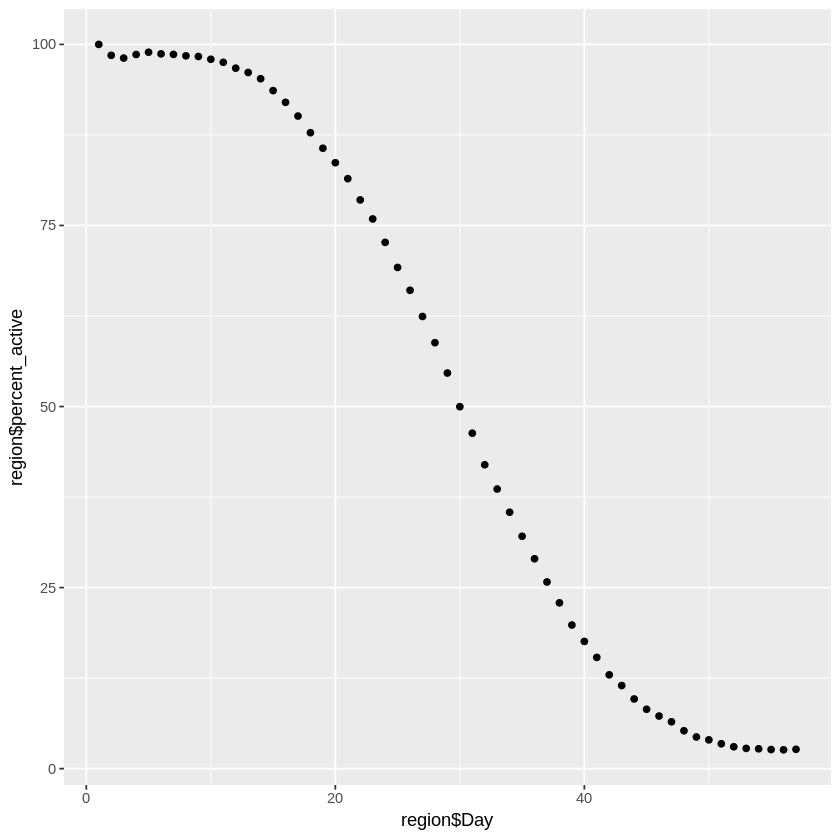

In [12]:
# Day vs %Closed Cases
region.scatter.plot <- ggplot(region, aes(x = region$Day, y = region$percent_active)) +
                        geom_point()
region.scatter.plot

In [13]:
tail(region)

Day,Confirmed,Active.Cases,percent_active,percent_closed
52,13159,398,3.024546,96.97545
53,13187,369,2.798210,97.20179
54,13209,362,2.740556,97.25944
55,13235,349,2.636947,97.36305
56,13259,345,2.602006,97.39799
57,13303,356,2.676088,97.32391


<br /><hr /><br />

## Data-Analysis <br />

In [14]:
# loading plotting/machine learning
library(tidyverse)
library(caret)

# setting the theme
theme_set(theme_classic())

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.1     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ dplyr   0.8.3
✔ tibble  2.1.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [15]:
set.seed(20) # generages same set of random sample every time

training.samples <- region$Day %>%
  createDataPartition(p = 0.8, list = FALSE)

train.data  <- region[training.samples, ]
test.data <- region[-training.samples, ]

In [16]:
head(train.data, 3)
head(test.data, 3)

Day,Confirmed,Active.Cases,percent_active,percent_closed
1,104,104,100.00000,0.000000
2,199,196,98.49246,1.507538
3,371,364,98.11321,1.886792


Day,Confirmed,Active.Cases,percent_active,percent_closed
4,645,636,98.60465,1.395349
13,6194,5954,96.12528,3.874717
15,7775,7279,93.62058,6.379421


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



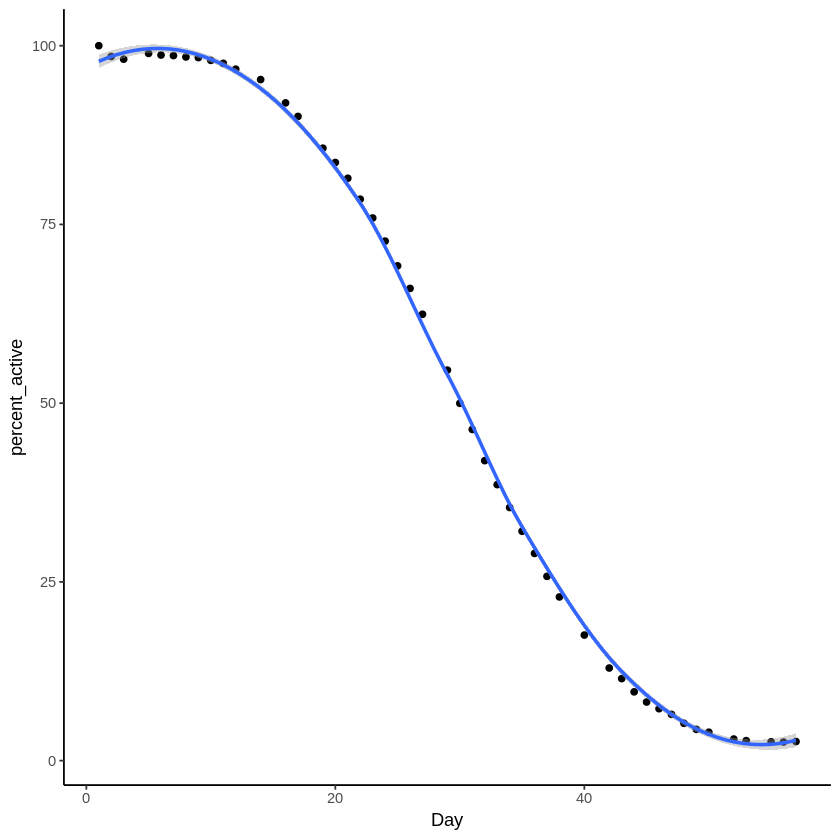

In [17]:
ggplot(train.data, aes(Day, percent_active) ) +
  geom_point() +
  stat_smooth()

<br /><hr /><br />

## Regrassion

1. ### Linear regression

In [18]:
# y = x
# Build the model

# pridiction by linear model
fit = lm(Day ~ percent_active, data = train.data)

In [19]:
# Predicting
predictions <- fit %>% predict(train.data)

In [20]:
# Model performance
data.frame(
  RMSE = RMSE(predictions, train.data$Day),
  R2 = R2(predictions, train.data$Day)
)

RMSE,R2
3.532498,0.9534814


<br />

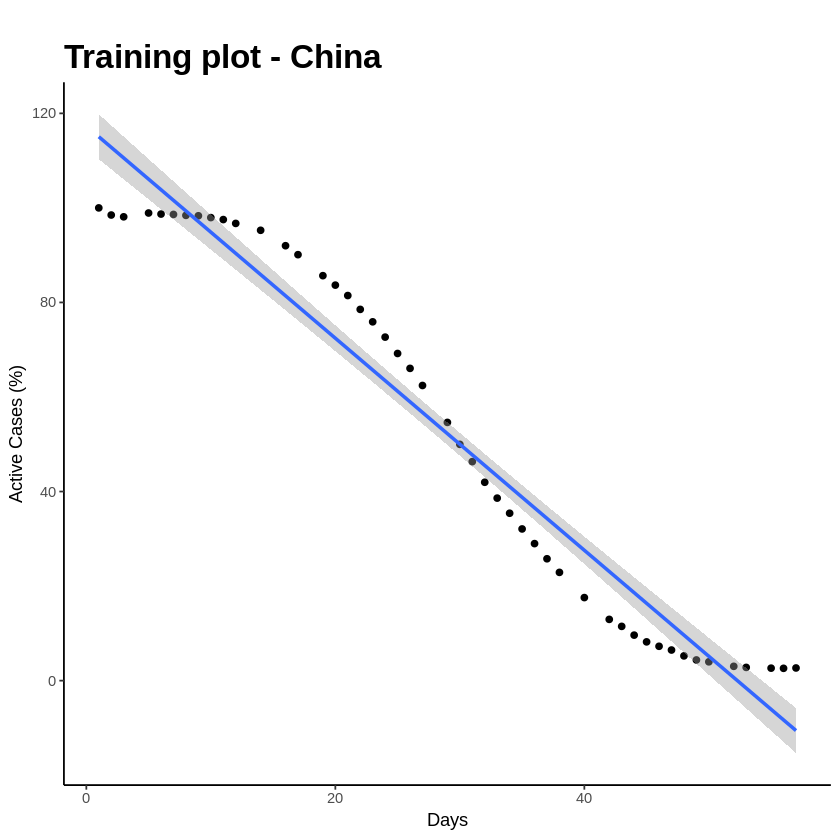

In [21]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

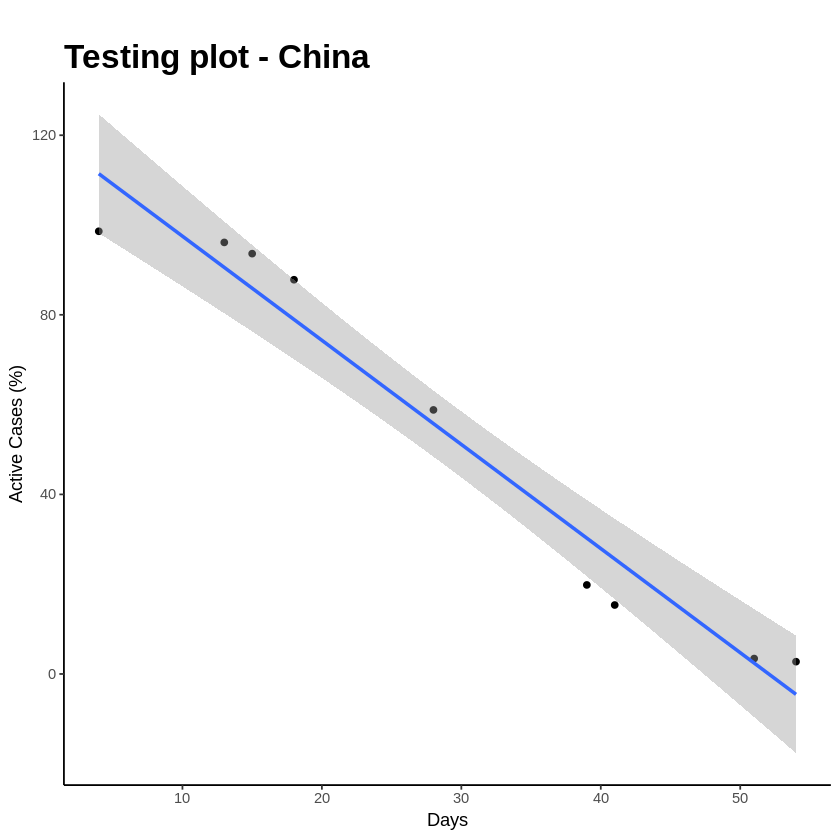

In [22]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

In [23]:

### can be TESTED in case of any problem in the ABOVE PLOT ###

#  # pridiction by linear model
#  pred <- predict(fit)   # fitting the model
#
#  plot(percent_active ~ Day, data = test.data)     #  "data = train.data"    is also possible
#  lines(train.data$Day, y=pred, col = "blue")


<br />

In [24]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit, test.data)
         )


tail(trained, 10)
tail(tested, 10)

,Day,percent_active,Pridicted_percent_active
39,46,7.264957,48.11743
40,47,6.473010,48.45406
41,48,5.229854,48.98247
42,49,4.372667,49.34683
43,50,3.977791,49.51468
44,52,3.024546,49.91987
45,53,2.798210,50.01607
46,55,2.636947,50.08462
47,56,2.602006,50.09947
48,57,2.676088,50.06798


Day,percent_active,Pridicted_percent_active
4,98.604651,9.292483
13,96.125283,10.346367
15,93.620579,11.411019
18,87.811406,13.880272
28,58.815548,26.205282
39,19.832552,42.775436
41,15.361007,44.676116
51,3.437001,49.744547
54,2.740556,50.040579


<br />

2. ### Polynomial regression

In [25]:
# y = x + I(x^2)...   ---->   a polynomial function
deg = 16  # degree of polynomial

# better and alternate way for line i.e. above
model = lm(percent_active ~ poly(Day, deg, raw = TRUE), data = train.data)

In [26]:
#head(test.data)
#head(train.data)

In [27]:
predictions <- model %>% predict(train.data)

Warning message in predict.lm(., train.data):
“prediction from a rank-deficient fit may be misleading”


In [28]:
# Model performance
data.frame(
  RMSE = RMSE(predictions, train.data$Day),
  R2 = R2(predictions, train.data$Day)
)

RMSE,R2
58.59968,0.9535058


<br /><br />

Warning message in predict.lm(model, newdata = data.frame(x = xseq), se.fit = se, :
“prediction from a rank-deficient fit may be misleading”


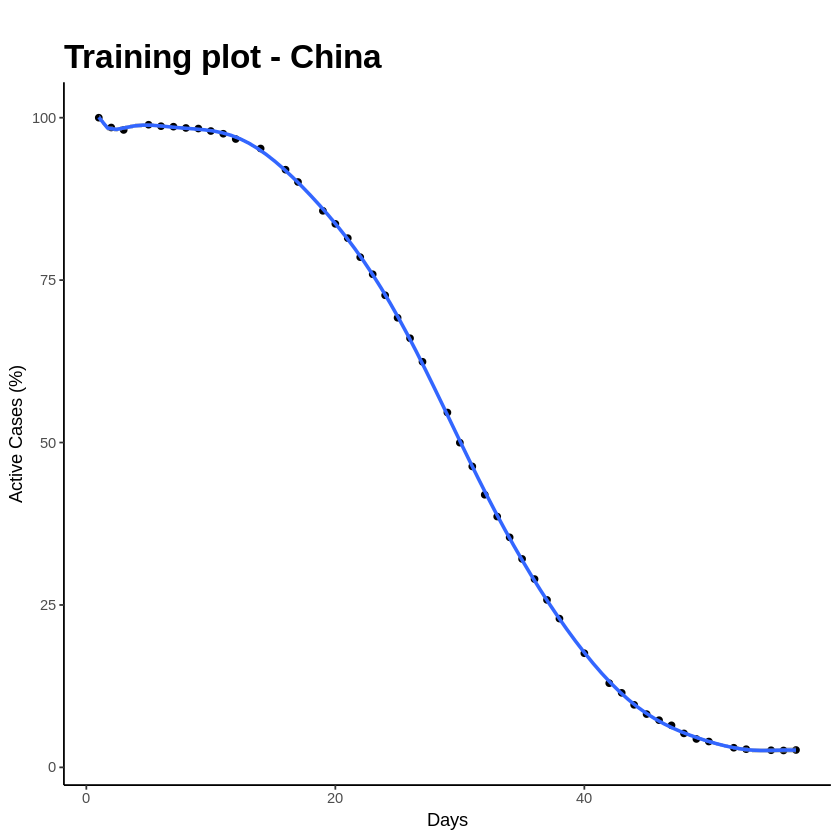

In [29]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

Warning message in predict.lm(model, newdata = data.frame(x = xseq), se.fit = se, :
“prediction from a rank-deficient fit may be misleading”
Warning message in qt((1 - level)/2, df):
“NaNs produced”


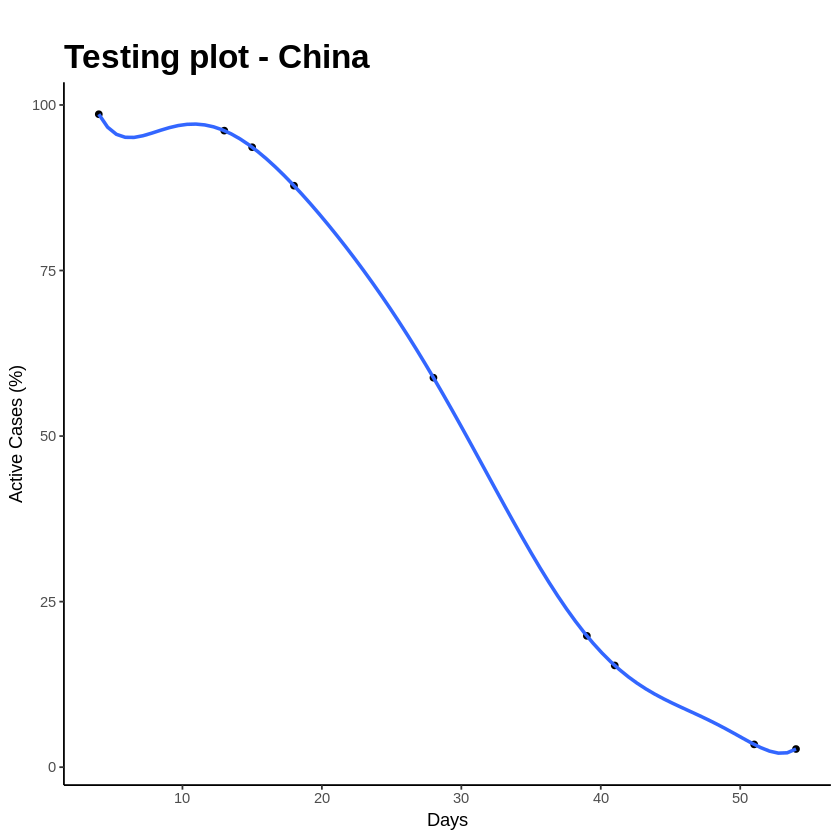

In [30]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

In [31]:

### can be TESTED in case of any problem in the ABOVE PLOT ###

#  # pridiction by polynomial model
#  pred <- predict(model)   # fitting the model
#
#  plot(percent_active ~ Day, data = test.data)     #  "data = train.data"    is also possible
#  lines(train.data$Day, y=pred, col = "blue")


<br /><br />

In [32]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(model, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(model, test.data)
         )


tail(trained, 10)
tail(tested, 10)

Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, test.data):
“prediction from a rank-deficient fit may be misleading”


,Day,percent_active,Pridicted_percent_active
39,46,7.264957,7.116415
40,47,6.473010,6.135176
41,48,5.229854,5.310308
42,49,4.372667,4.602725
43,50,3.977791,3.985590
44,52,3.024546,3.026870
45,53,2.798210,2.737020
46,55,2.636947,2.609293
47,56,2.602006,2.660969
48,57,2.676088,2.655583


Day,percent_active,Pridicted_percent_active
4,98.604651,98.775524
13,96.125283,96.135424
15,93.620579,93.516263
18,87.811406,88.056481
28,58.815548,58.220623
39,19.832552,20.180574
41,15.361007,15.343639
51,3.437001,3.453946
54,2.740556,2.605630


<br /><hr /><br />

## Predictions

In [33]:
test_Miscellaneous = data.frame(
                        Day = NaN,
                        Confirmed = NaN,
                        Active.Cases = NaN,
                        percent_active = NaN,
                        percent_closed = NaN
                     )

In [34]:
# 13th March ---> day 52
dNo = 58    # get the day no. to pridict

test_Miscellaneous$'Day' = dNo

<br /> 
1. #### By Linear Model

In [35]:
# modeling variable  --->  fit
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_active")],
                percent_pridicted = predict(fit, test_Miscellaneous)
             )
Prediction

Day,percent_active,percent_pridicted
58,NaN,NaN


<br /> 
2. #### By Polynomial Model

In [36]:
# modeling variable  --->  model
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_active")],
                percent_pridicted = predict(model, test_Miscellaneous)
             )
Prediction

Warning message in predict.lm(model, test_Miscellaneous):
“prediction from a rank-deficient fit may be misleading”


Day,percent_active,percent_pridicted
58,NaN,2.674994


<hr /> <br />

In [ ]:
# world on day 58
# 92.63192 ---> @deg = 16
# 88.90763 ---> @deg = 19